## A small Rant on object detection
Object detection is a complex task within the computer vision field, but it is highly valued and widely used. While it is more challenging than classification or semantic segmentation, it is a necessary starting point for instance segmentation.It has both love and hatred. The `iou` metric iteself on pycocotools is 600 lines. `NMS` is super slow on cpu and applying effectively on GPUs requires knowldege of `cuda programming` (triton will save us). So my hunt for simple and effective solutions never stops. This blog is one step towards that.

### Complexity:
Object detection involves dividing an image into a grid of smaller windows, or "anchor boxes," and identifying the objects within each window. This process can be challenging, as an image may contain a large number of objects and the anchor boxes can number in the hundreds of thousands. Additionally, accurately classifying such a large number of anchor boxes is a complex task. 


### Required everywhere: 
Almost everywhere we need to localize objects to process them furter. 
- In the process of digitizing documents, the goal is often to recognize and extract various components such as words, sentences, blocks of text, and paragraphs. 
- In self-driving technology, object detection is used to identify and recognize various objects such as other vehicles, humans, and traffic signs.
- In the insurance industry, object detection is used to locate and identify specific objects and any damage they may have sustained. For example, object detection can be used to identify defects on a car by segmenting the car and localizing the damaged areas.
- In medical there are several use cases as below 


#### In medical 
Ask [ChatGPT AI](https://chat.openai.com/chat#) and it will spit 100's of use-cases in each domain. Some of them are as below
- In cancer detection, object detection algorithms can be used to identify and classify tumors in medical images such as CT scans or mammograms.
- In cell biology, object detection can be used to locate and identify specific cells or organelles within microscopy images.
- In medical robotics, object detection can be used to identify and locate objects within the operating room, allowing the robot to perform tasks such as surgical instrument manipulation or wound closure.
- In telemedicine, object detection can be used to identify and extract relevant information from medical documents such as lab reports or discharge summaries, making it easier for doctors to access and analyze patient data.
- In medical image analysis, object detection can be used to identify and classify abnormalities or abnormalities in medical images, such as detecting fractures or identifying abnormalities in x-ray images.


In this process, I found `ATSS` paper which tried to simplify a lot of things. 

### Adaptive Training Sample Selection ([ATSS](https://arxiv.org/pdf/1912.02424.pdf))
- bridges the gap between anchor- based and anchor-free detectors
- through a series of experiments, a conclusion can be drawn that tiling multiple anchors per location on the image to detect objects is not necessary.

If there is a way to get rid of multiple anchors per location in a constructive way, I will choose it as we can get rid of finding `Optimal Anchors`. Lets see how this paper assigns gts to anchor boxes to train the model effectively.

In [1]:
import numpy as np
import PIL
import re
from pathlib import Path
from pycocotools.coco import COCO
from PIL import Image
import requests
import plotly.express as px
from io import BytesIO
import bbox_visualizer as bbv
from albumentations import SmallestMaxSize, PadIfNeeded, Compose, BboxParams

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("bmh")

In [2]:
data = COCO("/Users/prakash/Downloads/detr/data/coco/annotations/instances_val2017.json")
imgids = list(data.imgs.keys())

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


## Steps involved 
- step-1 : read the image and bbox 
- step-2 : resize image and bbox 
- step-3 : Generate anchors 
- step-4 : implement ATSS 
- step-5 : Calculate the Recall

## 1. Read the image and bbox

In [3]:
def load_img(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return  np.asarray(img)

def thumbnail(img, size=256):
    if not isinstance(img, PIL.Image.Image): img = Image.fromarray(img)
    w, h = img.size
    ar = h/w 
    return img.resize((size, int(size*ar)))

def coco_bbox_xyxy(bbox):
    bbox[:, 2] = bbox[:, 0]+bbox[:, 2]
    bbox[:, 3] = bbox[:, 1]+bbox[:, 3]
    return bbox

def get_bbox_catid(data, img_id):
    annotids = data.getAnnIds(imgIds=[img_id])
    annots = data.loadAnns(ids=annotids)
    if len(annots) == 0: return [], [], []
    bbox = np.asarray([i["bbox"] for i in annots])
    bxyxy = coco_bbox_xyxy(bbox.copy()).astype(np.int64)
    catid = np.asarray([i["category_id"] for i in annots])
    labels = np.asarray([data.cats[i]["name"] for i in catid])
    return bxyxy, labels, catid

def get_img_bbox_catid(data, img_id, network_call=True):
    bxyxy, labels, catid = get_bbox_catid(data, img_id)
    imginfo = data.imgs[img_id]
    img = load_img(imginfo["coco_url"]) if network_call else np.zeros((imginfo["height"], imginfo["width"], 3))
    return img, bxyxy, labels, catid

def image_grid(imgs, rows, cols):
    if not isinstance(imgs[0], PIL.Image.Image): imgs = [Image.fromarray(img) for img in imgs]
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def vis_bbox_labels(img, bbox, labels=None, bbox_color=(255, 255, 255)):
    img = bbv.draw_multiple_rectangles(img, bbox, thickness=2, bbox_color=bbox_color)
    if labels is not None: img = bbv.add_multiple_labels(img, labels, bbox)
    return img

> fails when there are no bounding boxes for an image

In [6]:
imgid = imgids[np.random.randint(len(imgids))]
pimg, bbox, labels, catid = get_img_bbox_catid(data, imgid)
bbox.shape, labels.shape, catid.shape, pimg.shape

((4, 4), (4,), (4,), (360, 640, 3))

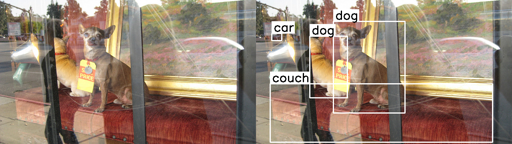

In [7]:
thumbnail(image_grid([pimg, vis_bbox_labels(pimg, bbox, labels)], 1, 2), size=512)

### valid boxes 

In [8]:
w = bbox[:, 2] - bbox[:, 0]
h = bbox[:, 3] - bbox[:, 1]
hw = np.stack([w, h]).T
valid = (hw>3).sum(1) == 2
valid

array([ True,  True,  True,  True])

In [9]:
def valid_boxes(bbox, thr=3):
    w = bbox[:, 2] - bbox[:, 0]
    h = bbox[:, 3] - bbox[:, 1]
    hw = np.stack([w, h]).T
    valid = (hw>thr).sum(1) == 2
    return valid

In [10]:
index = valid_boxes(bbox)
bbox, labels, catid = bbox[index], labels[index], catid[index]
bbox.shape, labels.shape, catid.shape

((4, 4), (4,), (4,))

## Step-2 Resize image and Pad 

In [11]:
bbox_params = bbox_params=BboxParams(format="pascal_voc", label_fields=["class_labels"])
transforms = Compose([SmallestMaxSize(max_size=800), 
                      PadIfNeeded(pad_height_divisor=32, pad_width_divisor=32, min_height=None, min_width=None)], 
                      bbox_params=bbox_params)

def resize_pad(transforms, img, bbox, labels):
    tt = transforms(image=img, bboxes=bbox, class_labels=labels)
    img, new_bxyxy = tt["image"], np.asarray(tt["bboxes"]).astype(np.int64)
    return img, new_bxyxy

In [12]:
nimg, nbbox = resize_pad(transforms, pimg, bbox, labels)
nimg.shape, nbbox.shape

((800, 1440, 3), (4, 4))

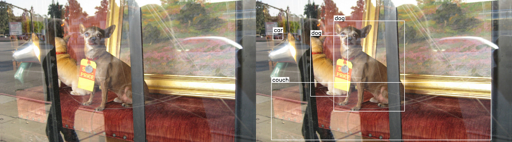

In [13]:
thumbnail(image_grid([nimg, vis_bbox_labels(nimg, nbbox, labels)], 1, 2), size=512)

## Step-3 Generate Centers and Anchors 
- Generate centers on the image based on stride.
- Generate one bbox per center.

In [14]:
strides = [16, 32, 64, 128, 256, 512]

In [15]:
import copy 

def get_ctrs(img, stride=16):
    shape = np.asarray(img.shape[:2])/stride
    y = np.arange(0, shape[0], step=1)
    x = np.arange(0, shape[1], step=1)
    yx, xy = np.meshgrid(x, y)
    return np.stack([yx, xy]).reshape(2, -1).T

def get_ctrs_on_img(img, stride=16):
    ctrs = get_ctrs(img, stride)
    ctrs = ctrs*stride + (stride/2)
    return ctrs

def vis_ctr(img, ctr):
    nimg = copy.deepcopy(img)
    for x, y in ctr: nimg[int(y)-4: int(y)+4, int(x)-4: int(x)+4, :] = [255, 0, 0]
    return nimg
    

def vis_ctrs(img, ctrs):
    imgs = []
    for ctr in ctrs:
        timg = vis_ctr(nimg, ctr)
        imgs.append(timg)
    return image_grid(imgs, rows=1, cols=len(imgs))

### Centers 

In [16]:
ctrs = [get_ctrs_on_img(nimg, s) for s in strides] 

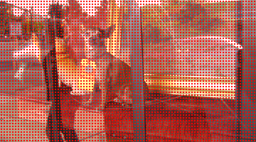

In [17]:
thumbnail(vis_ctr(nimg, ctrs[0]))

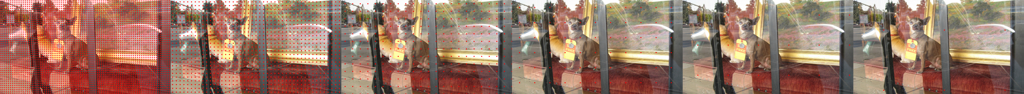

In [18]:
thumbnail(vis_ctrs(nimg, ctrs), size=1024)

### Anchors 

In [19]:
ctr = ctrs[0]
stride = strides[0]
ctr, stride

(array([[   8.,    8.],
        [  24.,    8.],
        [  40.,    8.],
        ...,
        [1400.,  792.],
        [1416.,  792.],
        [1432.,  792.]]),
 16)

In [20]:
hw = np.repeat(stride, ctr.shape[0]).repeat(2).reshape(-1, 2)
hw

array([[16, 16],
       [16, 16],
       [16, 16],
       ...,
       [16, 16],
       [16, 16],
       [16, 16]])

In [21]:
anchor = np.hstack([ctr, hw])
anchor

array([[   8.,    8.,   16.,   16.],
       [  24.,    8.,   16.,   16.],
       [  40.,    8.,   16.,   16.],
       ...,
       [1400.,  792.,   16.,   16.],
       [1416.,  792.,   16.,   16.],
       [1432.,  792.,   16.,   16.]])

> convert to xyxy

In [22]:
anchor[:, 0] = anchor[:, 0] - (anchor[:, 2]/2)
anchor[:, 1] = anchor[:, 1] - (anchor[:, 3]/2)
anchor[:, 2] = anchor[:, 0] + (anchor[:, 2])
anchor[:, 3] = anchor[:, 1] + (anchor[:, 3])
anchor

array([[   0.,    0.,   16.,   16.],
       [  16.,    0.,   32.,   16.],
       [  32.,    0.,   48.,   16.],
       ...,
       [1392.,  784., 1408.,  800.],
       [1408.,  784., 1424.,  800.],
       [1424.,  784., 1440.,  800.]])

In [23]:
h, w = nimg.shape[:2]
anchor[:, 0] = anchor[:, 0].clip(0, w)
anchor[:, 1] = anchor[:, 1].clip(0, h)
anchor[:, 2] = anchor[:, 2].clip(0, w)
anchor[:, 3] = anchor[:, 3].clip(0, h)
anchor

array([[   0.,    0.,   16.,   16.],
       [  16.,    0.,   32.,   16.],
       [  32.,    0.,   48.,   16.],
       ...,
       [1392.,  784., 1408.,  800.],
       [1408.,  784., 1424.,  800.],
       [1424.,  784., 1440.,  800.]])

In [24]:
def xycwh_xyxy(bbox):
    bbox[:, 0] = bbox[:, 0] - (bbox[:, 2]/2)
    bbox[:, 1] = bbox[:, 1] - (bbox[:, 3]/2)
    bbox[:, 2] = bbox[:, 0] + (bbox[:, 2])
    bbox[:, 3] = bbox[:, 1] + (bbox[:, 3])
    return bbox


def clip_bbox(bbox, img):
    h, w = nimg.shape[:2]
    bbox[:, 0] = bbox[:, 0].clip(0, w)
    bbox[:, 1] = bbox[:, 1].clip(0, h)
    bbox[:, 2] = bbox[:, 2].clip(0, w)
    bbox[:, 3] = bbox[:, 3].clip(0, h)
    return bbox
    

def gen_anchor_per_stride(ctr, stride, img=None):
    hw = np.repeat(stride, ctr.shape[0]).repeat(2).reshape(-1, 2)
    anchor = np.hstack([ctr, hw])
    if img is not None: anchor = clip_bbox(anchor, img)
    return xycwh_xyxy(anchor).astype(np.int64)

> keep `img=None` when u dont want to clip the anchor boxes. 

In [25]:
anchors = [gen_anchor_per_stride(ctr, stride, None) for stride, ctr in zip(strides, ctrs)]
[i.shape for i in anchors]

[(4500, 4), (1125, 4), (299, 4), (84, 4), (24, 4), (6, 4)]

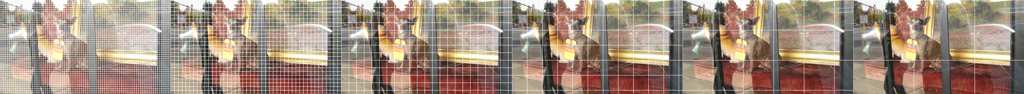

In [26]:
thumbnail(image_grid([vis_bbox_labels(nimg, anchor) for anchor in anchors], 1, len(anchors)), size=1024)

## Step-4 Implement ATSS 

### Input:
- G is a set of ground-truth boxes on the image - `bbox`
- L is the number of feature pyramid levels - `strides`
- $A_{i}$ is a set of anchor boxes from the ith pyramid levels - `any element in anchors`
- A is a set of all anchor boxes - `anchors`
- k is a quite robust hyperparameter with a default value of 9 `set below as atss_thr`


### method 
- calculate L2 distance between $A_{i}$ and G
- select k (`[atss_thr]`) anchors which are near to G per level.
- calculate iou with above selected anchors and set threshold (mean+std). > thr are pos anchors
- From above selected anchors, select anchors which have centers within the object
- These are our positive anchor boxes

> Lets do one for level

In [27]:
atss_thr = 9
level = 2
stride = strides[level]
stride

64

In [28]:
bboxc = np.ones((nbbox.shape[0], 2))
bboxc[:, 0] = (nbbox[:, 2] - nbbox[:, 0])/2
bboxc[:, 1] = (nbbox[:, 3] - nbbox[:, 1])/2
bboxc, bboxc.shape

(array([[199. , 254.5],
        [ 28. ,  20. ],
        [104.5, 171. ],
        [618. , 162. ]]),
 (4, 2))

In [29]:
ctr = ctrs[level]
anchor = anchors[level]
ctr.shape, anchor.shape

((299, 2), (299, 4))

> L2 distance 

we have [N, 2] Gts and [M, 2] ctrs, subtracting them using `broadcasting`
```
M, 2 -> [1, M, 2]
N, 2 -> [N, 1, 2]
        ---------
        [N, M, 2]
```

In [30]:
l2d = (((ctr[None] - bboxc[:, None, :])**2).sum(2)**0.5)
l2d.shape

(4, 299)

In [31]:
def cal_ctr(bbox):
    #bbox is x1, y1, x2, y2 out [(x2-x1)/2, (y2-y1)/2]
    bboxc = np.ones((bbox.shape[0], 2))
    bboxc[:, 0] =  bbox[:, 0] + ((bbox[:, 2] - bbox[:, 0])/2)
    bboxc[:, 1] = bbox[:, 1] + ((bbox[:, 3] - bbox[:, 1])/2)
    return bboxc

def calc_l2d(ctr, bbox):
    bboxc = cal_ctr(bbox)
    l2d = (((ctr[None] - bboxc[:, None, :])**2).sum(2)**0.5)
    return l2d

In [32]:
cal_ctr(nbbox)

array([[636. , 371.5],
       [123. , 204. ],
       [410.5, 371. ],
       [704. , 626. ]])

In [33]:
l2d = calc_l2d(ctr, nbbox)
l2d.shape

(4, 299)

In [34]:
nbbox

array([[ 437,  117,  835,  626],
       [  95,  184,  151,  224],
       [ 306,  200,  515,  542],
       [  86,  464, 1322,  788]])

> select k anchors from Ai whose center are closest to the center of ground-truth g based on L2 distance

In [35]:
topk = l2d.argsort(1)[:, :atss_thr]
topk, topk.shape

(array([[124, 125, 147, 148, 101, 102, 123, 126, 146],
        [ 70,  71,  47,  48,  93,  94,  69,  46,  72],
        [121, 144, 120, 122, 143, 145,  98,  97,  99],
        [217, 218, 240, 241, 194, 195, 219, 216, 239]]),
 (4, 9))

In [36]:
sanchor = anchor[topk] #selected anchors per bbox
sanchor.shape

(4, 9, 4)

In [37]:
anchor[topk[1]]

array([[ 64, 192, 128, 256],
       [128, 192, 192, 256],
       [ 64, 128, 128, 192],
       [128, 128, 192, 192],
       [ 64, 256, 128, 320],
       [128, 256, 192, 320],
       [  0, 192,  64, 256],
       [  0, 128,  64, 192],
       [192, 192, 256, 256]])

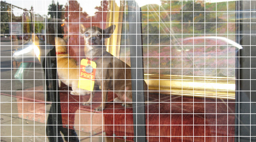

In [38]:
thumbnail(vis_bbox_labels(nimg, anchor.astype(np.int64)), size=256)

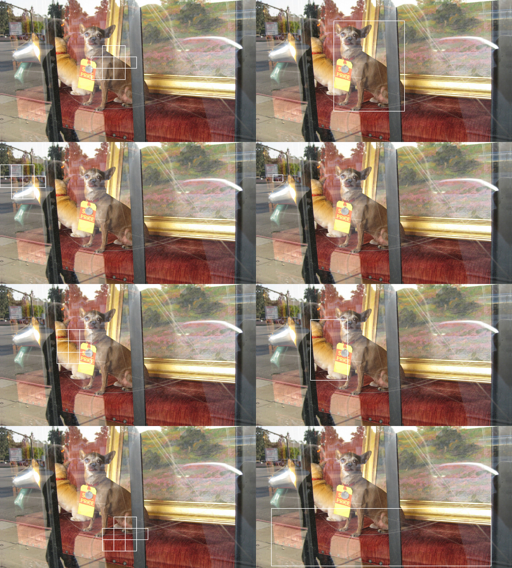

In [39]:
vis_sanchor = image_grid([vis_bbox_labels(nimg, s.astype(np.int64)) for s in sanchor], rows=len(sanchor), cols=1)
vis_nbbox = image_grid([vis_bbox_labels(nimg, [s]) for s in nbbox], rows=len(nbbox), cols=1)
thumbnail(image_grid([vis_sanchor, vis_nbbox], rows=1, cols=2), size=512)

### Lets do this for all the levels `A`

In [40]:
l2d_all = [calc_l2d(ctr, nbbox) for ctr in ctrs]
topk = [l2d.argsort(1)[:, :atss_thr] for l2d in l2d_all]
sanchors = [anchor[tk] for anchor, tk in zip(anchors, topk)]
sctr = [ctr[tk] for ctr, tk in zip(ctrs, topk)]
[i.shape for i in sanchors]

[(4, 9, 4), (4, 9, 4), (4, 9, 4), (4, 9, 4), (4, 9, 4), (4, 6, 4)]

In [41]:
def anchors_ctrs_based_on_l2(anchors, ctrs, gt_bbox, atss_thr=9):
    l2d_all = [calc_l2d(ctr, gt_bbox) for ctr in ctrs]
    topk = [l2d.argsort(1)[:, :atss_thr] for l2d in l2d_all]
    sanchors = [anchor[tk] for anchor, tk in zip(anchors, topk)]
    sctr = [ctr[tk] for ctr, tk in zip(ctrs, topk)]
    return sanchors, sctr, topk

In [42]:
sanchors, sctr, topk = anchors_ctrs_based_on_l2(anchors, ctrs, nbbox)

In [43]:
level = np.hstack([np.ones(i.shape)+n for n, i in enumerate(topk)])
idx = np.hstack(topk)
idx_level = np.concatenate([idx[:, None], level[:, None]], axis=1).transpose((0, 2, 1))
fanchors = np.hstack(sanchors)
fctrs = np.hstack(sctr)
fanchors.shape, fctrs.shape, level.shape, idx.shape, idx_level.shape

((4, 51, 4), (4, 51, 2), (4, 51), (4, 51), (4, 51, 2))

In [44]:
def concat_anchors_ctrs(anchors, ctrs, pos_idx_per_level):
    level = np.hstack([np.ones(i.shape)+n for n, i in enumerate(pos_idx_per_level)])
    idx = np.hstack(pos_idx_per_level)
    idx_level = np.concatenate([idx[:, None], level[:, None]], axis=1).transpose((0, 2, 1))
    fanchors = np.hstack(anchors)
    fctrs = np.hstack(ctrs)
    return fanchors, fctrs, idx_level

In [45]:
fanchors, fctrs, idx_level = concat_anchors_ctrs(sanchors, sctr, topk)
fanchors.shape, fctrs.shape, idx_level.shape

((4, 51, 4), (4, 51, 2), (4, 51, 2))

In [46]:
def pos_anchors_ctrs_l2d(anchors, ctrs, gt_bbox, atss_thr=9):
    sanchors, sctr, topk = anchors_ctrs_based_on_l2(anchors, ctrs, nbbox)
    fanchors, fctrs, idx_level = concat_anchors_ctrs(sanchors, sctr, topk)
    return fanchors, fctrs, idx_level

In [47]:
fanchors, fctrs, idx_level = pos_anchors_ctrs_l2d(anchors, ctrs, nbbox)
fanchors.shape, fctrs.shape, idx_level.shape

((4, 51, 4), (4, 51, 2), (4, 51, 2))

> calculate IOU 

compute IoU between sanchors and Gt (nbbox)

In [48]:
import numpy as np

def bbox_iou(bboxes1, bboxes2):
    # Get the coordinates of the intersection rectangle.
    x1 = np.maximum(bboxes1[:, None, 0], bboxes2[:, 0])
    y1 = np.maximum(bboxes1[:, None, 1], bboxes2[:, 1])
    x2 = np.minimum(bboxes1[:, None, 2], bboxes2[:, 2])
    y2 = np.minimum(bboxes1[:, None, 3], bboxes2[:, 3])
    
    # Calculate the area of the intersection rectangle.
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    
    # Calculate the area of each bounding box.
    bboxes1_area = (bboxes1[:, 2] - bboxes1[:, 0]) * (bboxes1[:, 3] - bboxes1[:, 1])
    bboxes2_area = (bboxes2[:, 2] - bboxes2[:, 0]) * (bboxes2[:, 3] - bboxes2[:, 1])
    
    # Calculate the IoU.
    iou = intersection / (bboxes1_area[:, None] + bboxes2_area - intersection)
    
    return iou

In [49]:
x = np.asarray([[0, 0, 10, 10], [0, 0, 5, 5]])
y = np.asarray([[0, 0, 10, 10], [2, 2, 5, 5]])
ioum = bbox_iou(x, y)
ioum, ioum.shape, x.shape, y.shape

(array([[1.  , 0.09],
        [0.25, 0.36]]),
 (2, 2),
 (2, 4),
 (2, 4))

In [50]:
ioum = np.vstack([bbox_iou(b[None], fa) for b, fa in zip(nbbox, fanchors)])
ioum.shape

(4, 51)

In [51]:
mean_iou = ioum.mean(1)
iou_std = ioum.std(1)
iou_thr = mean_iou + iou_std
iou_thr

array([0.11634908, 0.12912895, 0.15110091, 0.09313116])

In [52]:
iou_thr = ioum >= iou_thr[...,None]
iou_thr.shape

(4, 51)

In [53]:
ioum[1][iou_thr[1]]

array([0.45714286, 0.29113924, 0.2       , 0.13142857])

In [54]:
def cal_iou_thr_idx(bbox, anchors):
    # based on iou_thr select bboxes
    ioum = np.vstack([bbox_iou(b[None], fa) for b, fa in zip(bbox, anchors)])
    mean_iou = ioum.mean(1)
    iou_std = ioum.std(1)
    iou_thr = mean_iou + iou_std
    iou_thr = ioum >= iou_thr[...,None]
    return ioum, iou_thr

In [55]:
ioum, iou_thr = cal_iou_thr_idx(nbbox, fanchors)
ioum.shape, iou_thr.shape

((4, 51), (4, 51))

> find ctrs within bbox

In [56]:
def find_pos(ctrs, bbox):
    pos = (ctrs[:, 0][None] >= bbox[:, 0][..., None]) & (ctrs[:, 0][None] <= bbox[:, 2][..., None]) & \
      (ctrs[:, 1][None] >= bbox[:, 1][..., None]) & (ctrs[:, 1][None] <= bbox[:, 3][..., None])
    return pos

In [57]:
pos = np.vstack([find_pos(ctr, b[None]) for ctr, b in zip(fctrs, nbbox)])
pos.shape

(4, 51)

In [58]:
def cal_pos_thr_idx(bbox, ctrs):
    pos = np.vstack([find_pos(ctr, b[None]) for ctr, b in zip(ctrs, bbox)])
    return pos

In [59]:
pos = cal_pos_thr_idx(nbbox, fctrs)
pos.shape

(4, 51)

> final pos anchors for each bbox

In [60]:
fpos = [i&j for i, j in zip(iou_thr, pos)]
pos_anchors = [anc[f] for anc, f in zip(fanchors, fpos)]
[i.shape for i in pos_anchors]

[(3, 4), (3, 4), (3, 4), (6, 4)]

In [61]:
pos_idx_level = [l[f] for l, f in zip(idx_level, fpos)]
pos_level = [l[f] for l, f in zip(level, fpos)]
pos_idx = [i_d[f] for i_d, f in zip(idx, fpos)]
pos_iou = [i_o[f] for i_o, f in zip(ioum, fpos)]

In [62]:
[i.shape for i in pos_idx_level]

[(3, 2), (3, 2), (3, 2), (6, 2)]

In [63]:
def pos_anchors_ctrs_idx_iou(bbox, anchors, ctrs, idx_level):
    ioum, iou_thr = cal_iou_thr_idx(bbox, anchors)
    pos = cal_pos_thr_idx(bbox, ctrs)
    fpos = [i&j for i, j in zip(iou_thr, pos)]
    pos_anchors = [anc[f] for anc, f in zip(anchors, fpos)]
    pos_ctrs = [anc[f] for anc, f in zip(ctrs, fpos)]
    pos_idx_level = [l[f] for l, f in zip(idx_level, fpos)]
    pos_iou = [i_o[f] for i_o, f in zip(ioum, fpos)]
    return pos_anchors, pos_ctrs, pos_idx_level, pos_iou

In [64]:
pos_anchors, pos_ctrs, pos_idx_level, pos_iou = pos_anchors_ctrs_idx_iou(nbbox, fanchors, fctrs, idx_level)

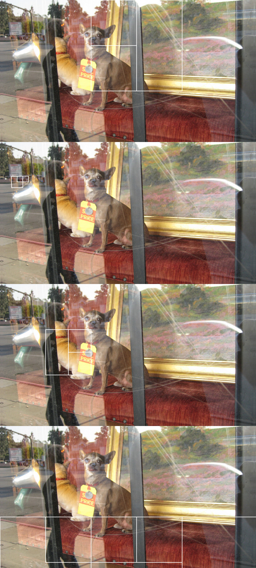

In [65]:
thumbnail(image_grid([vis_bbox_labels(nimg, s) for s in pos_anchors], rows=len(pos_anchors), cols=1), size=256)

### calculate classification and regression outputs
So, we finally got the 
- `indexes` of all pos anchors (`pos_idx_level`) for each bbox.
- pos anchor boxes
- pos centers.
- pos iou: iou with gt with each pos anchors

For the next step we just need `pos_iou` and `pos_idx_level`

> Incase if an anchor has iou with more than one Gt, the one with high iou will be assigned. 

In [66]:
## initialize the cls and reg matrices
cls = [np.zeros((i.shape[0], 3)) for i in anchors] # [label, iou, total_assigned]
reg = [np.ones((i.shape[0], 4))*-1 for i in anchors]
[i.shape for i in cls], [i.shape for i in reg]

([(4500, 3), (1125, 3), (299, 3), (84, 3), (24, 3), (6, 3)],
 [(4500, 4), (1125, 4), (299, 4), (84, 4), (24, 4), (6, 4)])

In [67]:
pos_idx_level

[array([[8., 5.],
        [2., 5.],
        [1., 6.]]),
 array([[273.,   2.],
        [274.,   2.],
        [ 70.,   3.]]),
 array([[27.,  4.],
        [39.,  4.],
        [ 7.,  5.]]),
 array([[14.,  5.],
        [15.,  5.],
        [13.,  5.],
        [ 4.,  6.],
        [ 3.,  6.],
        [ 5.,  6.]])]

#### reg co-efficent 
- Dx = A[x1+ (x2-x1)/2] - G[x1+ (x2-x1)/2]
- Dy = B[y1+ (y2-y1)/2] - G[y1+ (y2-y1)/2]
- w = A[x2-x1]/G[x2-x1]
- h = A[y2-y1]/G[y2-y1]

In [68]:
def calc_reg(anc, bbox):
    ax1, ay1, ax2, ay2 = anc
    x1, y1, x2, y2 = bbox
    w = (ax2-ax1)/(x2-x1)
    h = (ay2-ay1)/(y2-y1)
    x = ((ax1+((ax2-ax1)/2)) - (x1+((x2-x1)/2)))/(ax2-ax1)
    y = ((ay1+((ay2-ay1)/2)) - (y1+((y2-y1)/2)))/(ay2-ay1)
    return [x, y, w, h]

In [69]:
for num, (_box, _iou) in enumerate(zip(pos_idx_level, pos_iou)):
    _box = _box.astype(np.int64)
    for (x, y), _io in zip(_box, _iou):
        l, i, _ = cls[y-1][x] 
        if not (_io>i): continue
        cls[y-1][x] = [num+1, _io, num+1]
        anc = anchors[y-1][x]
        box = nbbox[num]
        reg[y-1][x] = calc_reg(anc, box)

In [70]:
def cal_outputs(anchors, pos_idx_level, pos_iou, labels):
    cls = [np.zeros((i.shape[0], 3)) for i in anchors]
    reg = [np.ones((i.shape[0], 4))*-1 for i in anchors]
    for num, (_box, _iou) in enumerate(zip(pos_idx_level, pos_iou)):
        _box = _box.astype(np.int64)
        for (x, y), _io in zip(_box, _iou):
            l, i, _ = cls[y-1][x] 
            if not (_io>i): continue
            cls[y-1][x] = [labels[num], _io, num+1]
            anc = anchors[y-1][x]
            box = nbbox[num]
            reg[y-1][x] = calc_reg(anc, box)
    return cls, reg

In [71]:
cls, reg = cal_outputs(anchors, pos_idx_level, pos_iou, catid) #Only use idx=0 while training for cls
cls, reg, anc = np.concatenate(cls), np.concatenate(reg), np.concatenate(anchors)
cls.shape, reg.shape, anc.shape

((6038, 3), (6038, 4), (6038, 4))

> calculate recall of the image

In [72]:
np.unique(cls[:, -1], return_counts=True)

(array([0., 1., 2., 3., 4.]), array([6023,    3,    3,    3,    6]))

In [73]:
np.unique(cls[:, -1], return_counts=True)[1][1:].shape[0], len(labels)

(4, 4)

In [74]:
def recall_per_img(cls, labels):
    numerator = np.unique(cls[:, -1], return_counts=True)[1][1:].shape[0]
    denom = len(labels)
    return numerator/denom

In [75]:
recall_per_img(cls, labels)

1.0

## Combining Everything 

> Get Anchors and centers for each level

In [76]:
nimg.shape, nbbox, labels, catid

((800, 1440, 3),
 array([[ 437,  117,  835,  626],
        [  95,  184,  151,  224],
        [ 306,  200,  515,  542],
        [  86,  464, 1322,  788]]),
 array(['dog', 'car', 'dog', 'couch'], dtype='<U5'),
 array([18,  3, 18, 63]))

In [77]:
strides = [16, 32, 64, 128, 256, 512]
ctrs = [get_ctrs_on_img(nimg, s) for s in strides] 
anchors = [gen_anchor_per_stride(ctr, stride, None) for stride, ctr in zip(strides, ctrs)]
[i.shape for i in anchors]

[(4500, 4), (1125, 4), (299, 4), (84, 4), (24, 4), (6, 4)]

> calculate cls, reg 

In [78]:
## subset anchors, ctrs using L2 distance
fanchors, fctrs, idx_level = pos_anchors_ctrs_l2d(anchors, ctrs, nbbox)
## Get pos anchors using iou
pos_anchors, pos_ctrs, pos_idx_level, pos_iou = pos_anchors_ctrs_idx_iou(nbbox, fanchors, fctrs, idx_level)
## Assign Gts to anchors 
cls, reg = cal_outputs(anchors, pos_idx_level, pos_iou, catid)
cls, reg = np.concatenate(cls), np.concatenate(reg)
cls.shape, reg.shape

((6038, 3), (6038, 4))

In [79]:
recall_per_img(cls, labels)

1.0

In [80]:
(cls[:, 0]>0).sum() # total pos

15

## Calculate stats Overall
- total Gt, total Pos, recall: Per image

In [81]:
from tqdm import tqdm

In [82]:
imgid = imgids[np.random.randint(len(imgids))]
pimg, bbox, labels, catid = get_img_bbox_catid(data, imgid, network_call=False)

In [83]:
empty_imgs = 0
total_gt, total_pos, rec = [], [], []
for imgid in tqdm(imgids):
    pimg, bbox, labels, catid = get_img_bbox_catid(data, imgid, network_call=False)
    if len(bbox) ==0: empty_imgs+=1;continue
    index = valid_boxes(bbox)
    bbox, labels, catid = bbox[index], labels[index], catid[index]
    if len(bbox) ==0: empty_imgs+=1;continue
    nimg, nbbox = resize_pad(transforms, pimg, bbox, labels)
    assert len(nbbox) == len(catid), f"failed: {imgid}"
    
    ## calculate gt
    fanchors, fctrs, idx_level = pos_anchors_ctrs_l2d(anchors, ctrs, nbbox)
    pos_anchors, pos_ctrs, pos_idx_level, pos_iou = pos_anchors_ctrs_idx_iou(nbbox, fanchors, fctrs, idx_level)
    cls, reg = cal_outputs(anchors, pos_idx_level, pos_iou, catid)
    cls, reg = np.concatenate(cls), np.concatenate(reg)
    rec.append(recall_per_img(cls, labels))
    total_pos.append((cls[:, 0]>0).sum())
    total_gt.append(len(labels))

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 170.76it/s]


In [84]:
empty_imgs, sum(total_gt), sum(total_pos)

(48, 36429, 135571)

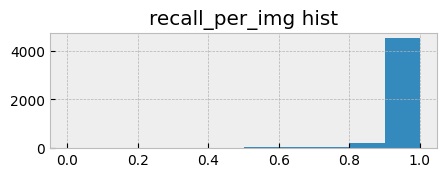

In [85]:
plt.figure(figsize=(5, 1.5))
plt.hist(rec)
plt.title("recall_per_img hist")
plt.show()

In [86]:
f"total_recall: {round(np.mean(rec) *100, 2)}"

'total_recall: 96.92'

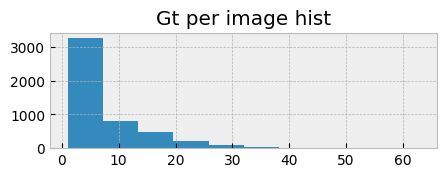

In [87]:
plt.figure(figsize=(5, 1.5))
plt.hist(total_gt)
plt.title("Gt per image hist")
plt.show()

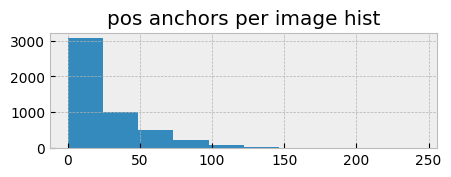

In [88]:
plt.figure(figsize=(5, 1.5))
plt.hist(total_pos)
plt.title("pos anchors per image hist")
plt.show()

> End: This is how we assign Gts using `ATSS` Technique